This fork is continued from https://github.com/lewiji/MiDaS/commit/2ae1545ad6941cc854c30675b2053fb8b7426aa7

Using the same method of the fork above, this line was added in [../tf/make_onnx_model.py](../tf/make_onnx_model.py)
```python
import torch.nn as nn

class View(nn.Module):
	def __init__(self, dim,  shape):
		super(View, self).__init__()
		self.dim = dim
		self.shape = shape

	def forward(self, input):
		new_shape = list(input.shape)[:self.dim] + list(self.shape) + list(input.shape)[self.dim+1:]
		return input.view(*new_shape)

nn.Unflatten = View
```

I don't know what this code does and whether it affects the output, but this alteration makes the onnx file to be created

In [1]:
import onnxruntime as rt

#Load the dpt_beit_large_512 onnx file
modelname = "dpt_beit_large_512"
onnx_model_path = f"../tf/{modelname}.onnx"

onnx_model = rt.InferenceSession(onnx_model_path)

In [2]:
import sys
midaspath = ".."
sys.path.append(midaspath)

from midas.model_loader import load_model, default_models
model_path = default_models[modelname]

import torch
import os

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("device: %s" % device)
pt_model, transform, net_w, net_h = load_model("cpu", os.path.join("../", model_path), modelname,
	optimize=False, square=True)

device: cpu


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded, number of parameters = 345M


(1080, 810, 3)


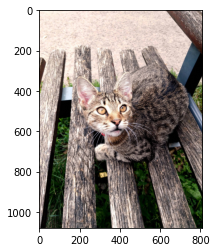

In [3]:
#Load the first image

from utils import read_image

import matplotlib.pyplot as plt

image = read_image("test.jpg")
print(image.shape)
plt.imshow(image)
plt.show()

In [4]:
img_input = transform({"image": image})["image"]

## Onnx

In [5]:
import numpy as np

input_name = onnx_model.get_inputs()[0].name
output_name = onnx_model.get_outputs()[0].name
onnx_output = onnx_model.run([output_name], {input_name: img_input.reshape(1, 3, net_h, net_w).astype(np.float32)})[0]

In [6]:
onnx_output.shape

(1, 512, 512)

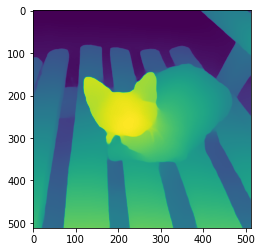

In [7]:
onnx_output = onnx_output[0]
plt.imshow(onnx_output)
plt.show()

## PyTorch

In [8]:
with torch.no_grad():
	sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
	pt_output = pt_model.forward(sample)
	pt_output = pt_output.squeeze().cpu().numpy()

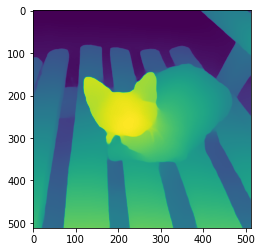

In [9]:
plt.imshow(onnx_output)
plt.show()

## Compare

In [10]:
err = onnx_output - pt_output

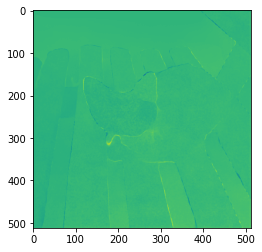

In [11]:
plt.imshow(err)
plt.show()

In [12]:
mse = (err ** 2).mean()
mse

3.5623038e-05

In [13]:
import math

print(f"rmse: {math.sqrt(mse):.8f}")
print(f"min: {err.min()}")
print(f"max: {err.max()}")
print(f"std: {err.std()}")

rmse: 0.00596850
min: -0.16552734375
max: 0.087890625
std: 0.005218607373535633


### Normalized

In [14]:
def normalize(arr: np.array):
	minval = arr.min()
	maxval = arr.max()
	return (arr - minval) / (maxval - minval)

onnx_output_norm = normalize(onnx_output)
pt_output_norm = normalize(pt_output)

norm_err = onnx_output_norm - pt_output_norm

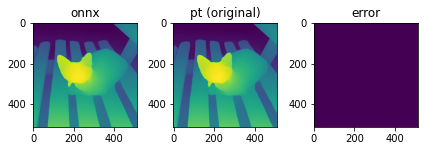

In [15]:
for i, im, title in zip([1, 2, 3], [onnx_output_norm, pt_output_norm, norm_err], ["onnx", "pt (original)", "error"]):
	plt.subplot(1, 3, i)
	plt.imshow(im, vmin=0, vmax=1)
	plt.title(title)

plt.tight_layout()
plt.show()

In [16]:
norm_mse = (norm_err ** 2).mean()
norm_rmse = math.sqrt(norm_mse)

for stat, val in zip(["rmse", "min", "max", "std"], [norm_rmse, norm_err.min(), norm_err.max(), norm_err.std()]):
	print(f"{stat}: {val:.8f}")

rmse: 0.00000050
min: -0.00001529
max: 0.00000775
std: 0.00000049


# 😀